In [2]:
from qiskit import QuantumCircuit, transpile
from math import pi, asin, sqrt, acos
from qiskit.primitives import Sampler as PrimitiveSampler
from itertools import repeat
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeCairoV2
from qiskit_ibm_runtime import Session, Sampler

/home/josue/Projects/physics/hermes/.venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


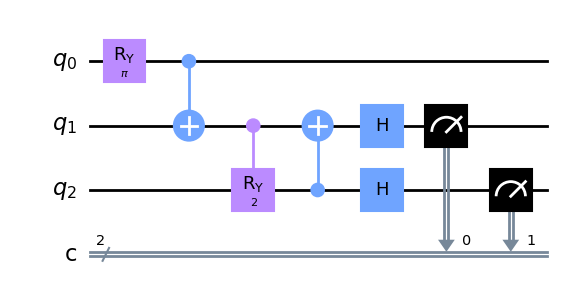

In [14]:
def build_circuit(p, theta, zne):
    alpha = 2 * acos(sqrt(p))
    q = QuantumCircuit(3, 2)
    q.ry(alpha, 0)
    q.cx(0, 1)
    q.cry(2 * theta, 1, 2)
    q.cx(2, 1)
    q.h(1)
    q.h(2)

    i = zne
    qf = q
    while i > 0:
        qf = qf.compose(q.inverse())
        qf = qf.compose(q)
        i -= 1

    qf.measure([1,2],[0,1])
    return qf


q = build_circuit(0, 1, 0)
q.draw("mpl")

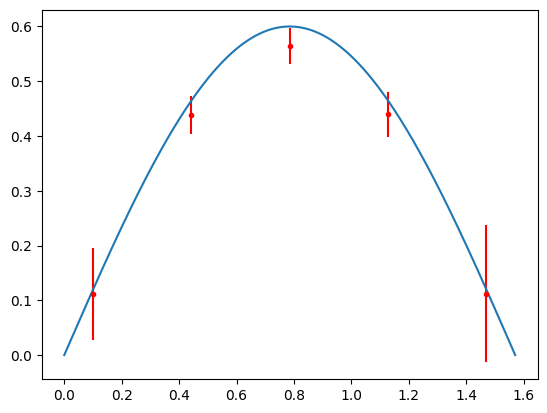

In [31]:
s_size = 5
N = 10**5
angles = 5
zne_size = 4
p = 0.4

circuits = []
thetas = np.linspace(0.1, pi / 2 - 0.1, angles)
for t in thetas:
    for i in range(zne_size):
        circuits.extend(repeat(build_circuit(p, t, i), s_size))

# job = PrimitiveSampler().run(circuits)

backend = FakeCairoV2()
job = backend.run(transpile(circuits, backend), shots=N)

con = []
err = []

for j in range(len(thetas)):
    for i in range(zne_size):
        # results = job.result().quasi_dists[i : s_size * (i + 1)]
        results = [
            {0: i["00"] / N, 1: i["01"] / N, 2: i["10"] / N, 3: i["11"] / N}
            for i in job.result().get_counts()
        ][i * s_size + j * angles * zne_size : s_size * (i + 1) + angles * zne_size * j]

        e1 = np.std([d[0] for d in results])
        e2 = np.std([d[1] for d in results])
        e3 = np.std([d[2] for d in results])
        e4 = np.std([d[3] for d in results])

        s1 = np.mean([d[0] for d in results])
        s2 = np.mean([d[1] for d in results])
        s3 = np.mean([d[2] for d in results])
        s4 = np.mean([d[3] for d in results])

        con.append(np.abs(s1 - s2 - s3 + s4))
        err.append(np.sqrt(e1**2 + e2**2 + e3**2 + e4**2))

zne_con = []
dC_AB=[]
for i in range(angles):
    znes = [1, 3, 5, 7]

    con_batch = con[i * zne_size : (i + 1) * zne_size]
    err_batch = err[i * zne_size : (i + 1) * zne_size]

    fit = np.polyfit(znes, con_batch, 1)
    zne_con.append(fit[1])

    dCp = [g1 / g2 for g1, g2 in zip(err_batch, con_batch)]
    s1d2 = sum([1 / g2**2 for g2 in dCp])
    ud2 = sum([g1 / g2**2 for g1, g2 in zip(znes, dCp)])
    u2d2 = sum([g1**2 / g2**2 for g1, g2 in zip(znes, dCp)])
    D = s1d2 * u2d2 - ud2**2
    dC_AB.append(4 * np.sqrt(u2d2 / D) * np.exp(fit[1]))


# plt.plot(thetas, zne_con, "o")
plt.errorbar(thetas, zne_con, dC_AB, fmt = 'r.')
theory_thetas = np.linspace(0, pi / 2, 300)
theory_con = (1 - p) * np.abs(np.sin(2 * th))
plt.plot(theory_thetas, theory_con)

plt.show()